In [1]:
from collections import defaultdict
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import scvelo as scv
#import velocyto as vcy
from os import listdir
from os.path import isfile, join
import glob
from collections import Counter
import loompy as lp
import numba
import llvmlite
import scipy.sparse

# import mnnpy
from matplotlib import colors

In [2]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0.2, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [3]:
sc.settings.set_figure_params(dpi=80)
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.7.1 pandas==1.3.3 scikit-learn==1.0 statsmodels==0.13.0rc0 python-igraph==0.9.6 louvain==0.7.0 pynndescent==0.5.4


In [4]:
pack_list = [numba,llvmlite,lp,pd,sns,scv]
for pack in pack_list:
    print(str(pack), pack.__version__)
    

<module 'numba' from 'C:\\Users\\giovanni\\anaconda3\\envs\\python39\\lib\\site-packages\\numba\\__init__.py'> 0.54.0
<module 'llvmlite' from 'C:\\Users\\giovanni\\anaconda3\\envs\\python39\\lib\\site-packages\\llvmlite\\__init__.py'> 0.37.0
<module 'loompy' from 'C:\\Users\\giovanni\\AppData\\Roaming\\Python\\Python39\\site-packages\\loompy\\__init__.py'> 3.0.6
<module 'pandas' from 'C:\\Users\\giovanni\\anaconda3\\envs\\python39\\lib\\site-packages\\pandas\\__init__.py'> 1.3.3
<module 'seaborn' from 'C:\\Users\\giovanni\\AppData\\Roaming\\Python\\Python39\\site-packages\\seaborn\\__init__.py'> 0.11.2
<module 'scvelo' from 'C:\\Users\\giovanni\\AppData\\Roaming\\Python\\Python39\\site-packages\\scvelo\\__init__.py'> 0.2.4


In [5]:
scv.set_figure_params('scanpy')  # for beautified visualization

In [6]:
sc.set_figure_params(dpi_save=500, frameon=True,
                     vector_friendly=True, fontsize=14,
                     figsize=None, color_map=None, format='pdf',
                     facecolor=None, transparent=True, ipython_format='png2x')


In [7]:
def get_cluster_proportions(adata,
                            cluster_key="cluster_final",
                            sample_key="replicate",
                            drop_values=None):

    adata_tmp = adata.copy()
    sizes = adata_tmp.obs.groupby([cluster_key, sample_key]).size()
    props = sizes.groupby(level=1).apply(lambda x: 100 * x / x.sum()).reset_index() 
    props = props.pivot(columns=sample_key, index=cluster_key).T
    props.index = props.index.droplevel(0)
    props.fillna(0, inplace=True)
    
    if drop_values is not None:
        for drop_value in drop_values:
            props.drop(drop_value, axis=0, inplace=True)
    return props


def plot_cluster_proportions(cluster_props, 
                             cluster_palette=None,
                             xlabel_rotation=1): 
    fig, ax = plt.subplots(dpi=600, figsize=(6, 24))
    fig.patch.set_facecolor("white")
    
    cmap = None
    if cluster_palette is not None:
        cmap = sns.palettes.blend_palette(
            cluster_palette, 
            n_colors=len(cluster_palette), 
            as_cmap=True)
   
    cluster_props.plot(
        kind="bar", 
        stacked=True, 
        ax=ax, 
        legend=None, 
        colormap=cmap
    )
    
    ax.legend(bbox_to_anchor=(1.01, 1), frameon=False, title="Cell Type")
    sns.despine(fig, ax)
    ax.tick_params(axis="x", rotation=xlabel_rotation)
    ax.set_xlabel(cluster_props.index.name.capitalize())
    ax.set_ylabel("Proportion")
    fig.tight_layout()
    
    return fig

In [8]:
filtered_symbol_unique = pd.read_csv("../geneid_symbol_filtered_unique.csv").set_index("gene_id")
filtered_symbol_unique

symbol
gene_id                       
AMEX60DD003449  AMEX60DD003449
AMEX60DD005685  AMEX60DD005685
AMEX60DD009250  AMEX60DD009250
AMEX60DD022557  AMEX60DD022557
AMEX60DD025407        HNRNPUL2
...                        ...
ERCC-00041          ERCC.00041
ERCC-00130          ERCC.00130
HoxA11_E1                    X
HoxA13_E1                  X.1
HoxA13_E2                  X.2

[52746 rows x 1 columns]

**Yu**

In [9]:
Andy_path = '../Seurat/Yu_Seurat_NoEarly.h5ad'
andy = sc.read_h5ad(Andy_path)

In [10]:
andy

AnnData object with n_obs × n_vars = 2047 × 99218
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.1', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

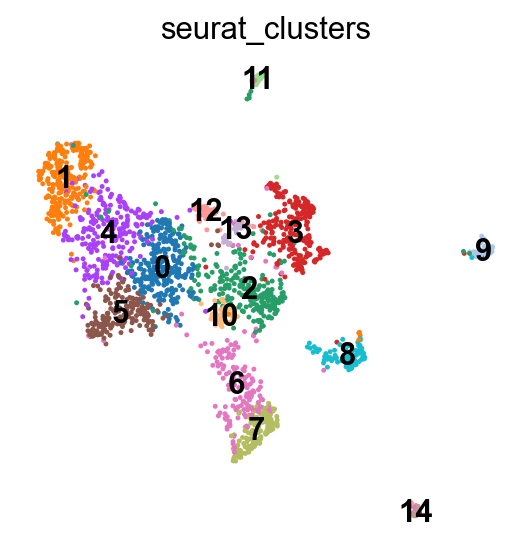

In [11]:
sc.pl.umap(andy, color=['seurat_clusters'], legend_loc='on data', size=20, frameon=False)

In [12]:
andy.obs

orig.ident  nCount_RNA  nFeature_RNA  nCount_SCT  nFeature_SCT  \
late9_05_C14       late    107779.0          3244    218874.0          3237   
pal1_01_A04         pal    220091.0          3018    219451.0          3001   
pal1_01_A02         pal     10836.0          1232    196370.0          8366   
pal1_01_A01         pal    177896.0          2921    217059.0          2916   
pal1_01_A06         pal    237127.0          3504    220378.0          3493   
...                 ...         ...           ...         ...           ...   
mid11_07_I06        mid    466883.0          5139    227461.0          3869   
mid11_07_I07        mid     67433.0          1851    228311.0          2179   
mid11_07_I08        mid    458106.0          5204    218107.0          4381   
mid11_07_I09        mid    140644.0          1994    224315.0          1990   
mid11_07_I10        mid    358531.0          2297    220603.0          2060   

             SCT_snn_res.1 seurat_clusters  
late9_05_C14             2               2  
pal1_01_A04              0               0  
pal1_01_A02              7               7  
pal1_01_A01              4               4  
pal1_01_A06              4               4  
...                    ...             ...  
mid11_07_I06             5               5  
mid11_07_I07             2               2  
mid11_07_I08             1               1  
mid11_07_I09             2               2  
mid11_07_I10             2               2  

[2047 rows x 7 columns]

In [13]:
andy.var

name
AMEX60DD000001  AMEX60DD000001
AMEX60DD000002  AMEX60DD000002
AMEX60DD000003  AMEX60DD000003
AMEX60DD000004  AMEX60DD000004
AMEX60DD000005  AMEX60DD000005
...                        ...
ERCC-00164          ERCC-00164
ERCC-00165          ERCC-00165
ERCC-00168          ERCC-00168
ERCC-00170          ERCC-00170
ERCC-00171          ERCC-00171

[99218 rows x 1 columns]

In [14]:
gene_info = pd.read_csv("../../Data/Annotation/AmexG_v6_DD.final_gene_information.csv",
                       sep = "\t")
gene_info.set_index("gene_id", inplace=True)
gene_info

chr      start        end strand     gene_symbol  \
gene_id                                                               
AMEX60DD000001  chr10p     313039     315424      +           ZFP37   
AMEX60DD000002  chr10p     313679     358550      -    LOC114595135   
AMEX60DD000003  chr10p     489232     514890      +    LOC101953204   
AMEX60DD000004  chr10p     697815     769805      -    LOC115462503   
AMEX60DD000005  chr10p     770040    1018740      +  AMEX60DD000005   
...                ...        ...        ...    ...             ...   
HoxD11           chr9q  427268357  427271492      -          HoxD11   
HoxD13           chr9q  427645475  427653868      -          HoxD13   
HoxD4            chr9q  426648258  426653184      -           HoxD4   
HoxD8            chr9q  427246176  427248458      -           HoxD8   
HoxD9            chr9q  427253324  427255269      -           HoxD9   

                  gene_biotype  first_transcript_id annotation_status  \
gene_id                                                                 
AMEX60DD000001  protein_coding  AMEX60DD301000001.1     Not annotated   
AMEX60DD000002  protein_coding  AMEX60DD201000002.1              Full   
AMEX60DD000003  protein_coding  AMEX60DD201000003.1        Fragmented   
AMEX60DD000004  protein_coding  AMEX60DD201000004.1              Full   
AMEX60DD000005  protein_coding  AMEX60DD201000005.1         Predicted   
...                        ...                  ...               ...   
HoxD11          protein_coding               HoxD11              Full   
HoxD13          protein_coding               HoxD13              Full   
HoxD4           protein_coding                HoxD4              Full   
HoxD8           protein_coding                HoxD8              Full   
HoxD9           protein_coding                HoxD9              Full   

                        nr_symbol    hs_symbol  percent_repeat  
gene_id                                                         
AMEX60DD000001         ZFP37 [nr]  ZNF568 [hs]       17.619600  
AMEX60DD000002  LOC114595135 [nr]  ZNF268 [hs]        1.052630  
AMEX60DD000003  LOC101953204 [nr]  ZNF850 [hs]       40.307100  
AMEX60DD000004  LOC115462503 [nr]  ZNF268 [hs]       10.541700  
AMEX60DD000005                  -            -        0.268998  
...                           ...          ...             ...  
HoxD11                          -            -        0.735595  
HoxD13                          -            -        0.000000  
HoxD4                           -            -        1.566210  
HoxD8                           -            -        1.756250  
HoxD9                           -            -        4.479580  

[99126 rows x 11 columns]

In [15]:
# ## Annotate with gene_info
# andy.var = andy.var.merge(gene_info, how='left', left_index=True, right_index=True)

# for index,row in andy.var.iterrows():
# #     print(row["gene_symbol"])
# #     print(index)
#     if pd.isnull(row["gene_symbol"]):
#         print(index)
# #         andy.var.gene_symbol.cat.add_categories(index, inplace=True)
#         andy.var.loc[index,"gene_symbol"] = index
    
# andy.var.set_index("gene_symbol", inplace=True)
# andy.var_names_make_unique()

In [16]:
## Filter by repeats
new_vars = andy.var.merge(filtered_symbol_unique, how='inner', left_index=True, right_index=True)
andy = andy[:,list(new_vars.index)]
andy.var = new_vars
andy.var.set_index("symbol", inplace=True)
andy.var_names_make_unique()

In [17]:
andy.var_names_make_unique()

In [18]:
andy.var

name
symbol                        
ZFP37           AMEX60DD000001
LOC114595135.4  AMEX60DD000002
LOC115462503    AMEX60DD000004
AMEX60DD000005  AMEX60DD000005
LOC115464621    AMEX60DD000006
...                        ...
ERCC.00164          ERCC-00164
ERCC.00165          ERCC-00165
ERCC.00168          ERCC-00168
ERCC.00170          ERCC-00170
ERCC.00171          ERCC-00171

[52730 rows x 1 columns]

In [19]:
sc.pp.neighbors(andy, n_neighbors=20, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


In [20]:
sc.tl.draw_graph(andy)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:39)


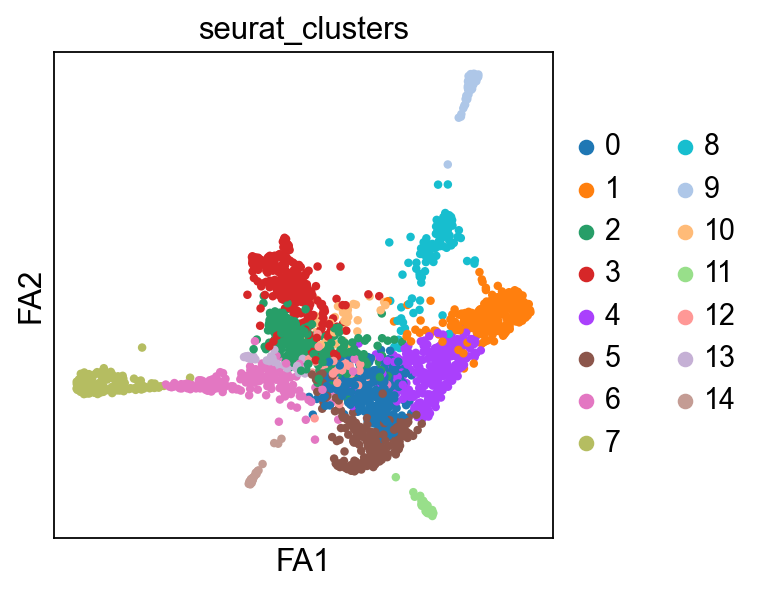

In [21]:
sc.pl.draw_graph(andy, color=['seurat_clusters'])

In [22]:
sc.pp.normalize_total(andy, target_sum=1e4)
sc.pp.log1p(andy)

normalizing counts per cell
    finished (0:00:00)


ranking genes
    finished: added to `.uns['t-test']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


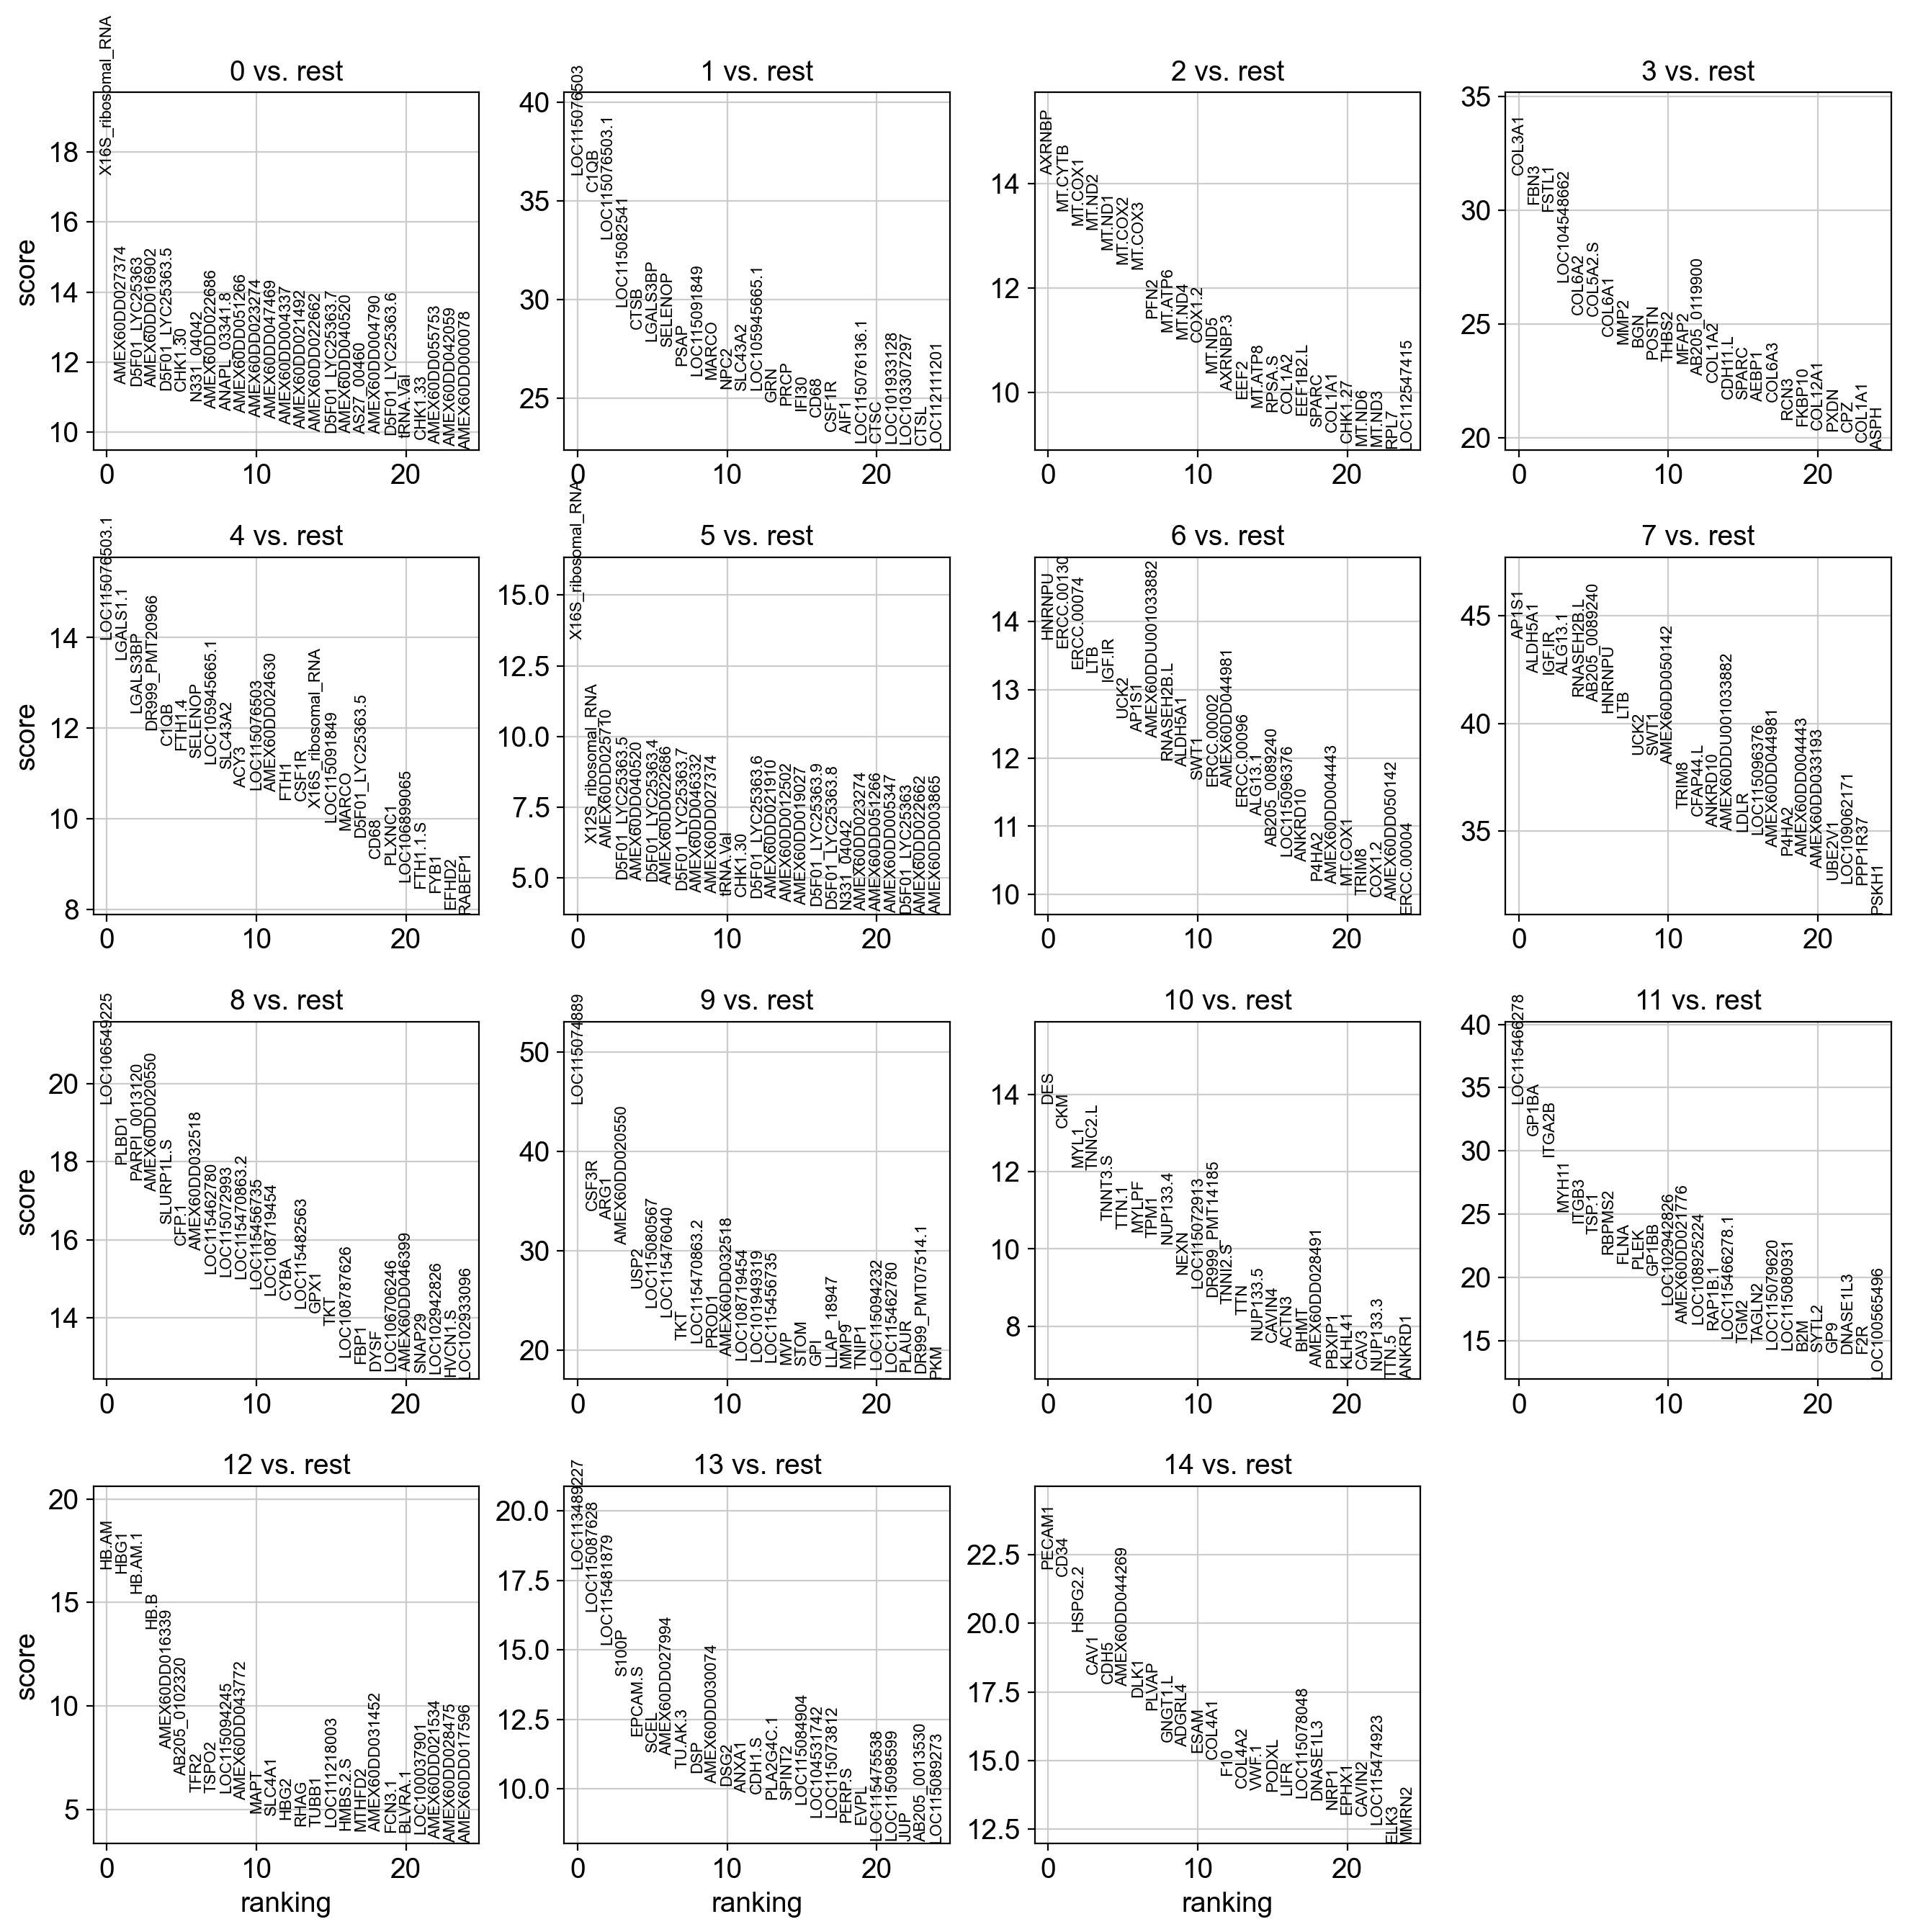

In [23]:
# Find marker genes
sc.settings.set_figure_params(dpi=100)

sc.tl.rank_genes_groups(andy, 'seurat_clusters', method='t-test_overestim_var', key_added='t-test')
sc.pl.rank_genes_groups(andy, n_genes=25, sharey=False, key='t-test')
sc.settings.set_figure_params(dpi=80)

ranking genes
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:15)


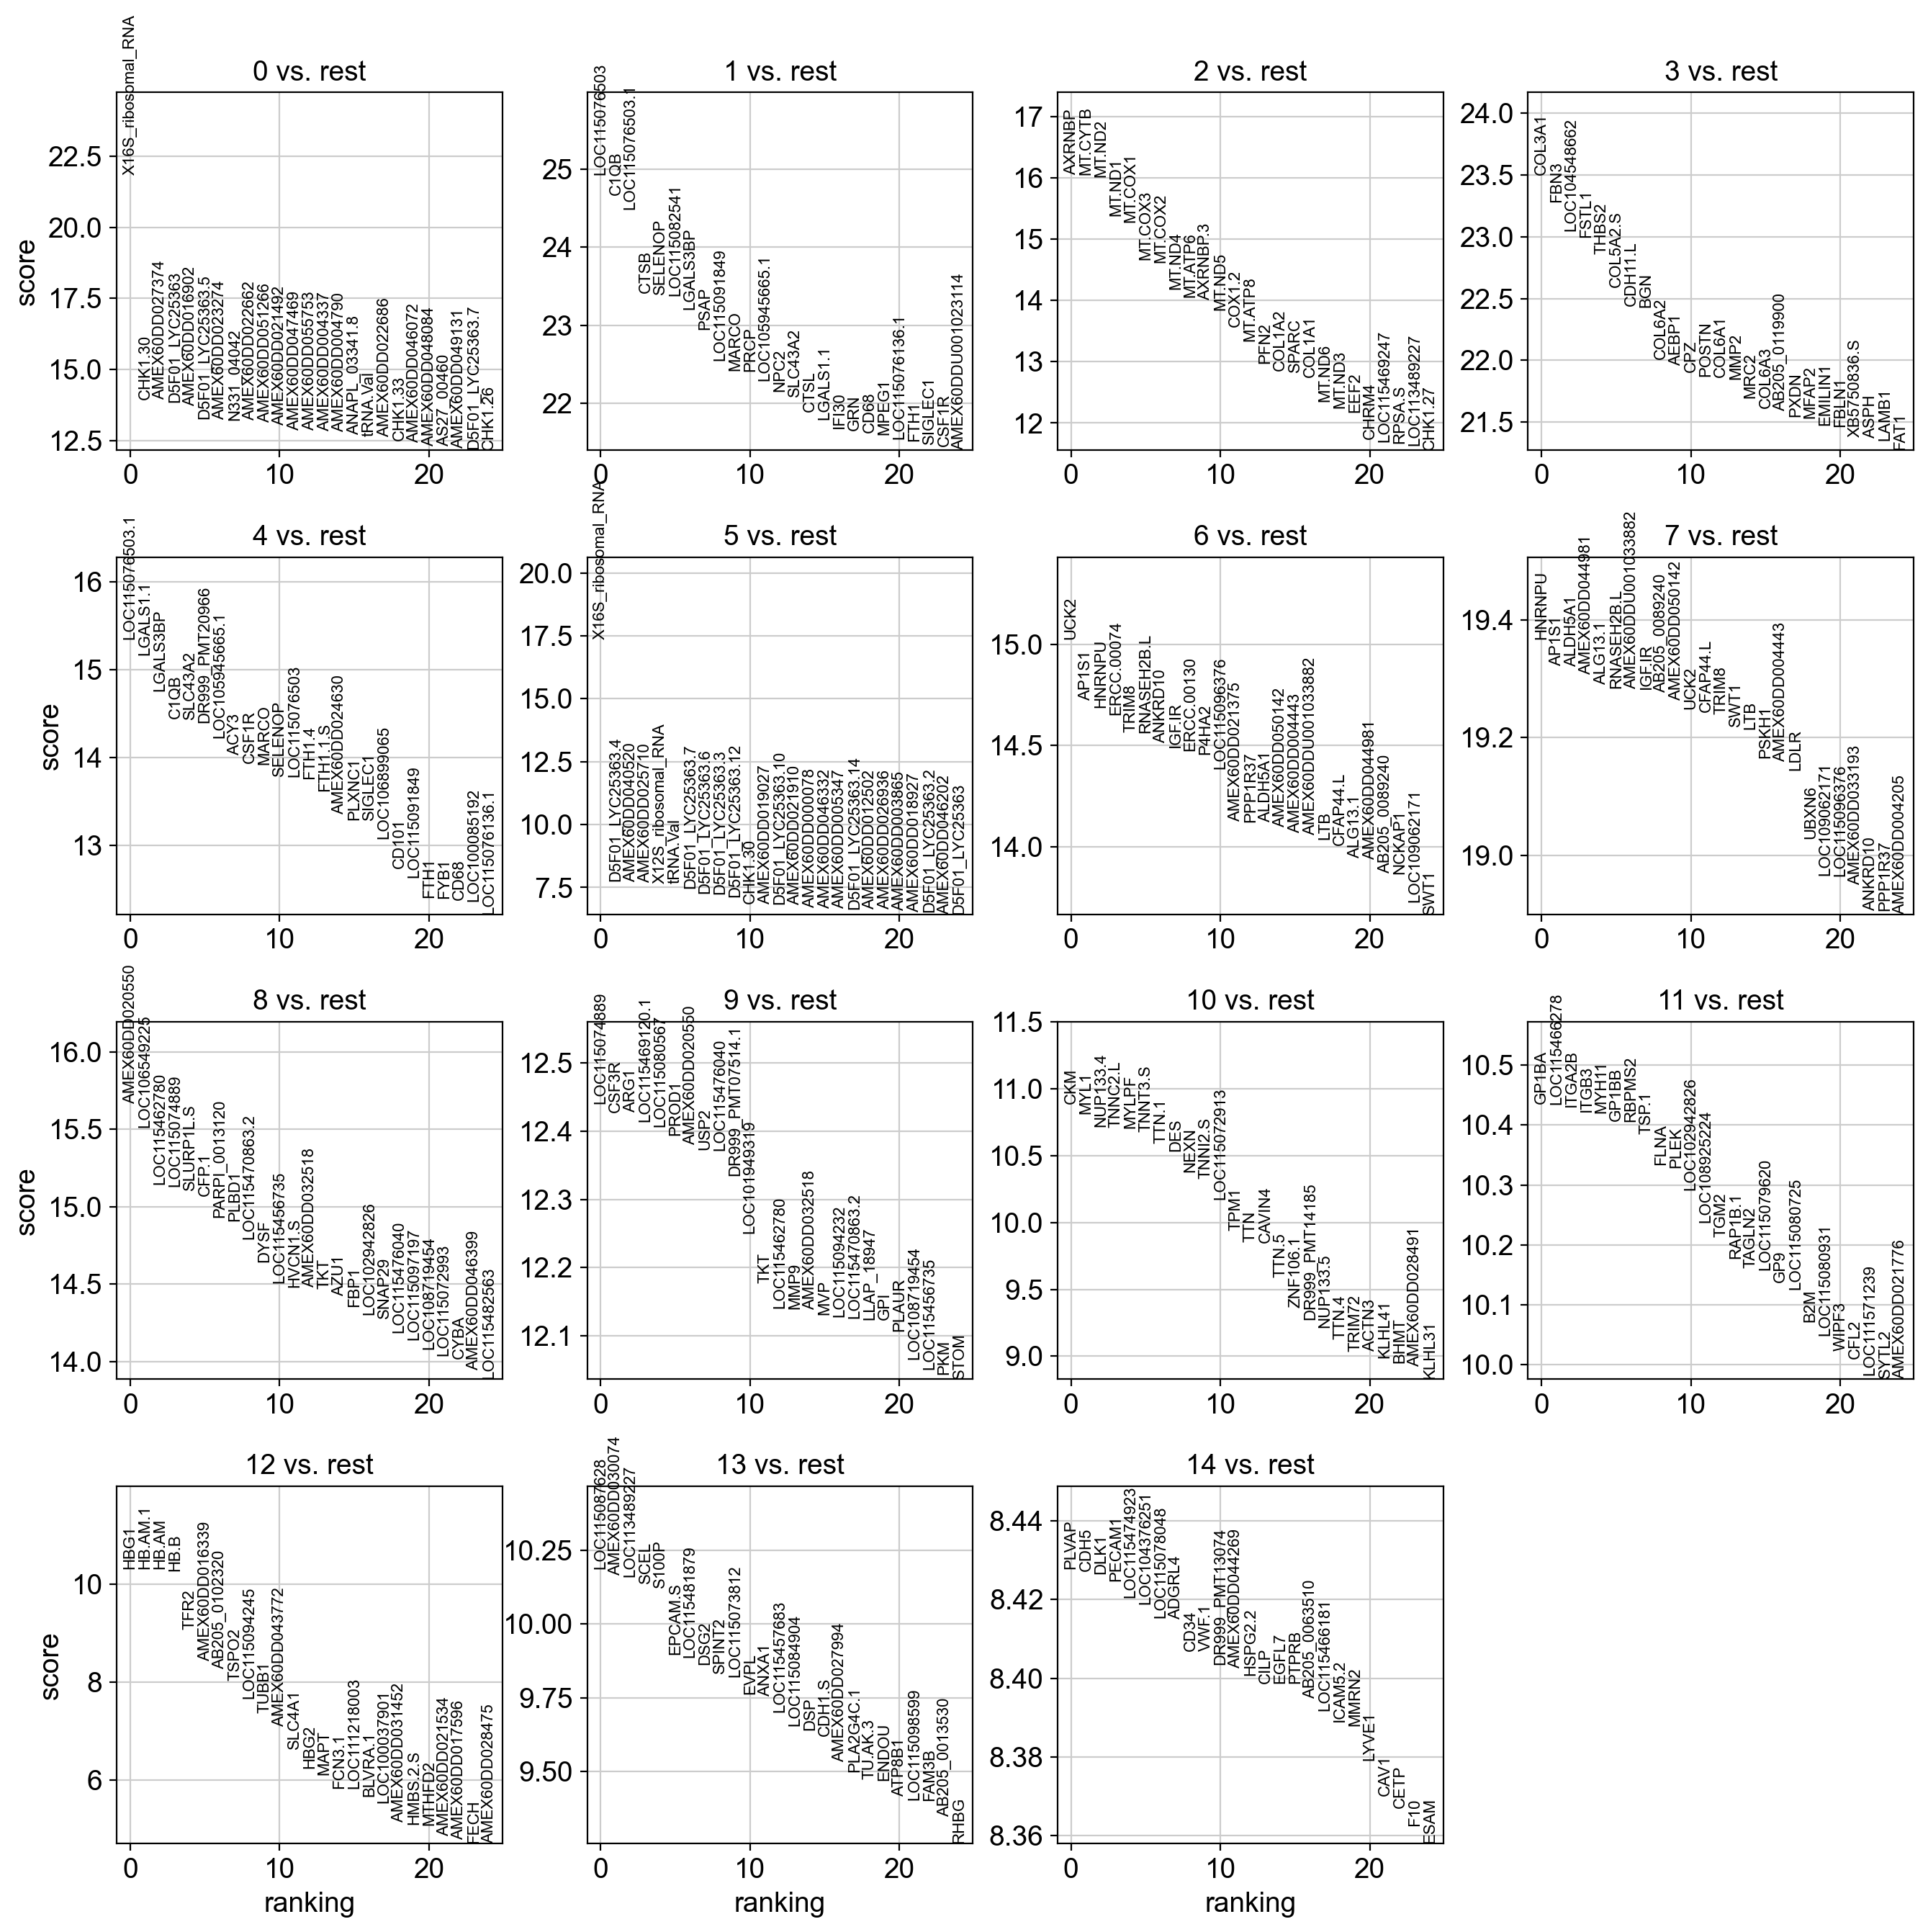

In [24]:
# Find marker genes
sc.settings.set_figure_params(dpi=100)

sc.tl.rank_genes_groups(andy, 'seurat_clusters', method='wilcoxon', key_added='wilcoxon')
sc.pl.rank_genes_groups(andy, n_genes=25, sharey=False, key='wilcoxon')
sc.settings.set_figure_params(dpi=80)

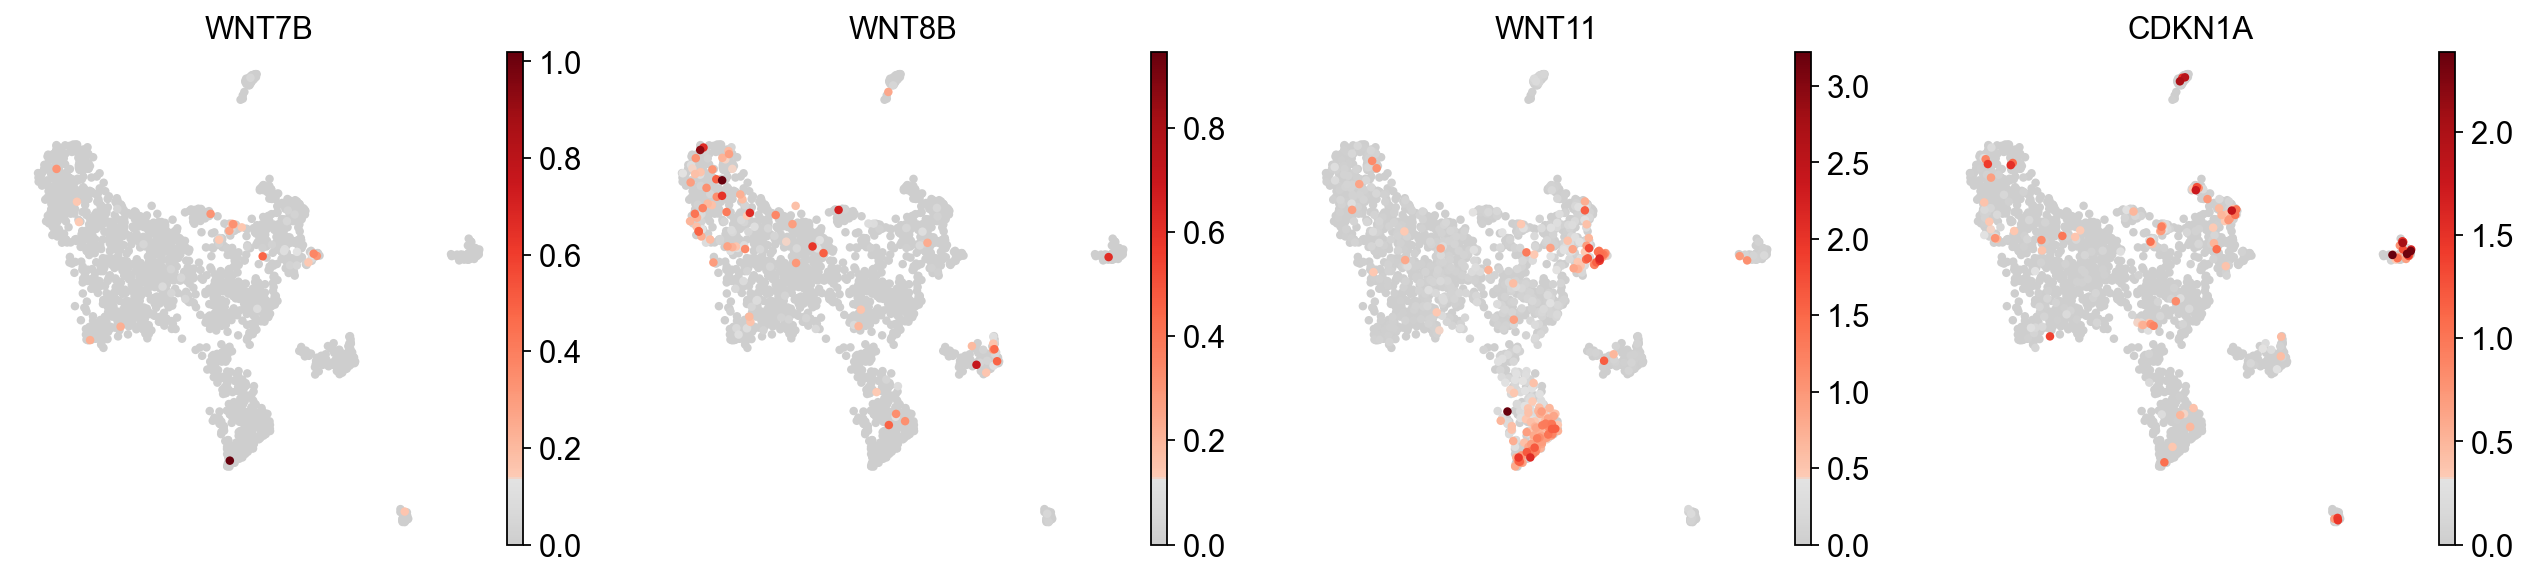

In [25]:
sc.pl.umap(andy, color=['WNT7B','WNT8B','WNT11','CDKN1A'],
           legend_loc="on data",
           use_raw=False,
           color_map = mymap,
           frameon=False,
           save='_genes_of_interest.pdf'
          )


In [26]:
old_to_new = {
    '0':'0',
    '1':'Macrophages',
    '2':'2',
    '3':'Connective TIssue',
    '4':'Macrophages',
    '5':'5',
    '6':'6',
    '7':'6',
    '8':'Neutrophil',         # HVCN1, CFP, AZU1 (Neutrophils), 
    '9':'9',
    '10':'Skeletal Muscle',
    '11':'11',
    '12':'Erythrocytes', # HBG1, HBB, TFR2 
    '13':'Epidermis', # SCEL, DSP, EVPL, DSG2, EPCAM
    '14':'Endothelial' # PLVAP, CDH5, PECAM1, VWF
}
andy.obs['cell types'] = (
    andy.obs['seurat_clusters']
    .map(old_to_new)
    .astype('category')
)

In [27]:
old_to_new = {
    '0':None,
    '1':'Macrophages',
    '2':None,
    '3':'Connective TIssue',
    '4':'Macrophages',
    '5':None,
    '6':None,
    '7':None,
    '8':'Neutrophil',         # HVCN1, CFP, AZU1 (Neutrophils), 
    '9':None,
    '10':'Skeletal Muscle',
    '11':None,
    '12':'Erythrocytes', # HBG1, HBB, TFR2 
    '13':'Epidermis', # SCEL, DSP, EVPL, DSG2, EPCAM
    '14':'Endothelial' # PLVAP, CDH5, PECAM1, VWF
}
andy.obs['ALT cell types'] = (
    andy.obs['seurat_clusters']
    .map(old_to_new)
    .astype('category')
)

In [28]:
andy.obs

orig.ident  nCount_RNA  nFeature_RNA  nCount_SCT  nFeature_SCT  \
late9_05_C14       late    107779.0          3244    218874.0          3237   
pal1_01_A04         pal    220091.0          3018    219451.0          3001   
pal1_01_A02         pal     10836.0          1232    196370.0          8366   
pal1_01_A01         pal    177896.0          2921    217059.0          2916   
pal1_01_A06         pal    237127.0          3504    220378.0          3493   
...                 ...         ...           ...         ...           ...   
mid11_07_I06        mid    466883.0          5139    227461.0          3869   
mid11_07_I07        mid     67433.0          1851    228311.0          2179   
mid11_07_I08        mid    458106.0          5204    218107.0          4381   
mid11_07_I09        mid    140644.0          1994    224315.0          1990   
mid11_07_I10        mid    358531.0          2297    220603.0          2060   

             SCT_snn_res.1 seurat_clusters   cell types ALT cell types  
late9_05_C14             2               2            2            NaN  
pal1_01_A04              0               0            0            NaN  
pal1_01_A02              7               7            6            NaN  
pal1_01_A01              4               4  Macrophages    Macrophages  
pal1_01_A06              4               4  Macrophages    Macrophages  
...                    ...             ...          ...            ...  
mid11_07_I06             5               5            5            NaN  
mid11_07_I07             2               2            2            NaN  
mid11_07_I08             1               1  Macrophages    Macrophages  
mid11_07_I09             2               2            2            NaN  
mid11_07_I10             2               2            2            NaN  

[2047 rows x 9 columns]

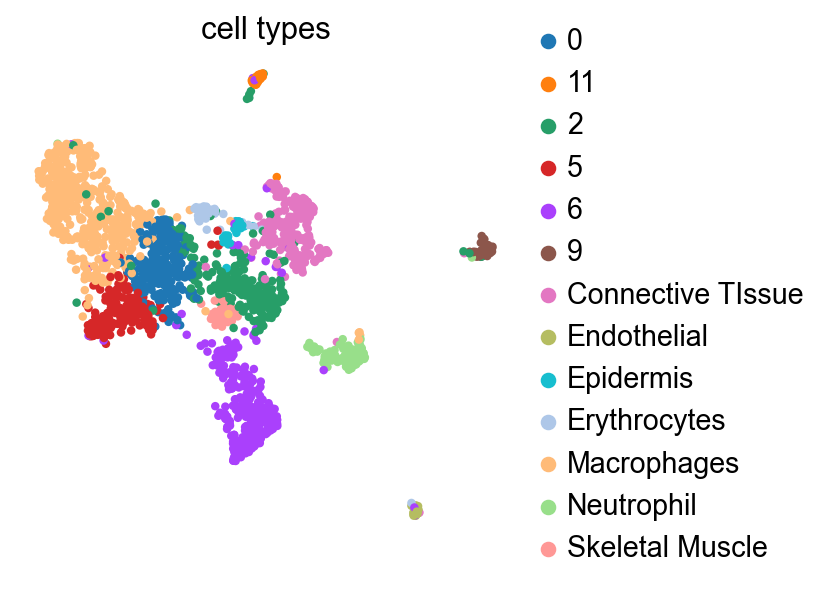

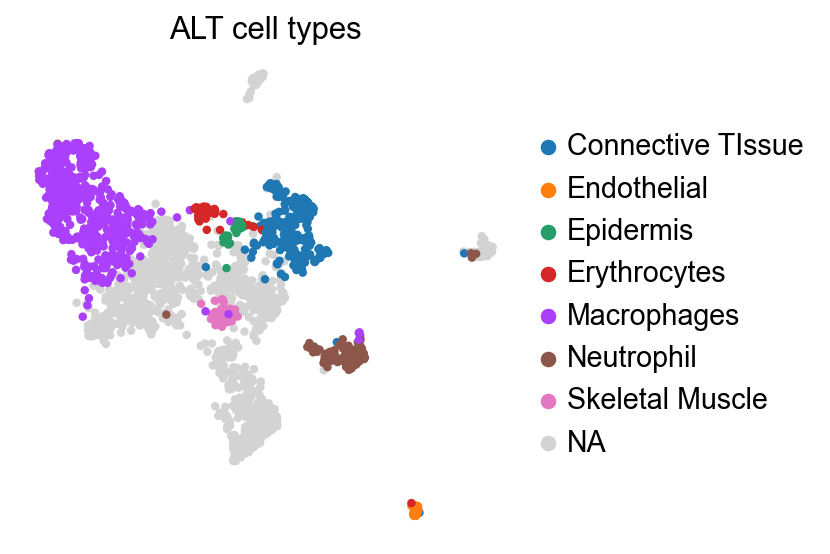

In [29]:
sc.pl.umap(andy,
           color=['cell types'],
           outline_color = ('white'),
           use_raw=False,
           color_map = mymap,
           frameon=False,
           save='_cell_types.pdf'
          )
sc.pl.umap(andy,
           color=['ALT cell types'],
           outline_color = ('white'),
           use_raw=False,
           color_map = mymap,
           frameon=False,
           save='_ALT_cell_types.pdf'
          )


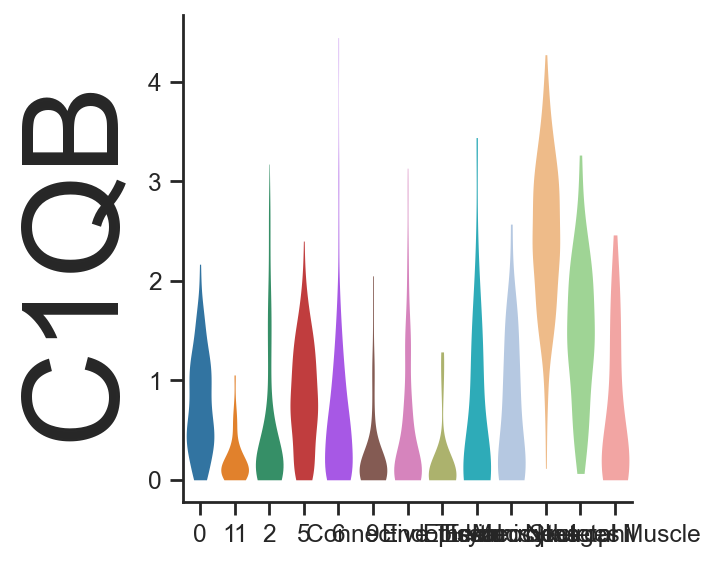

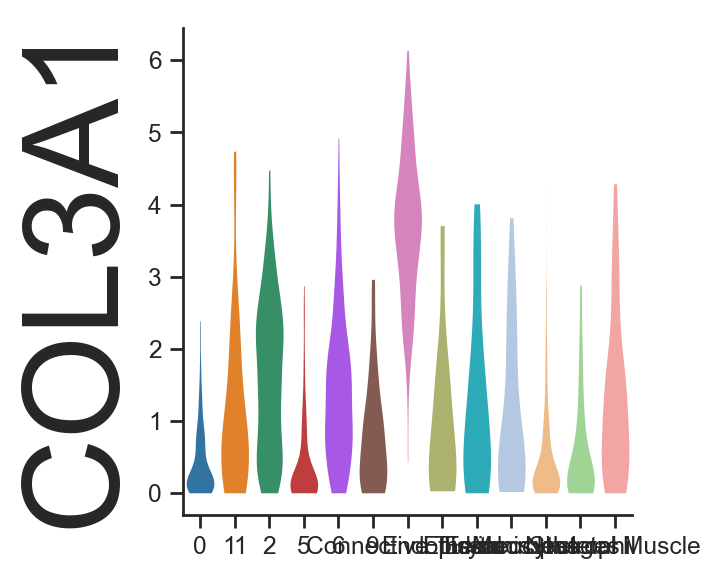

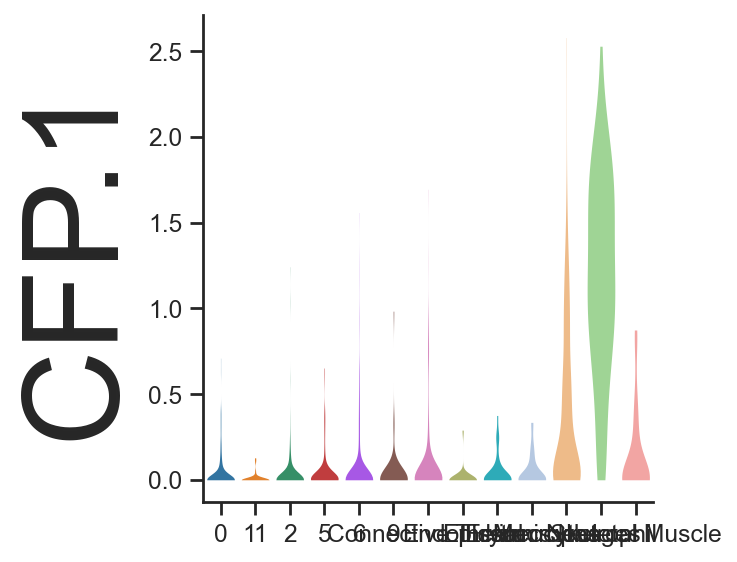

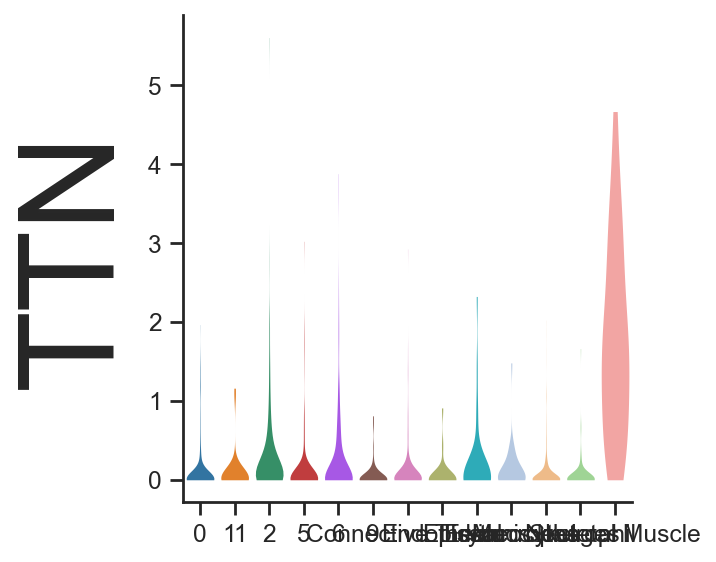

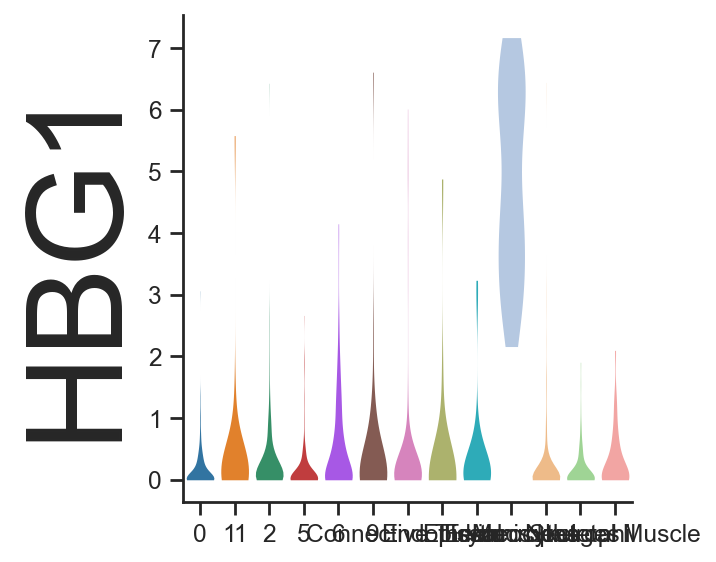

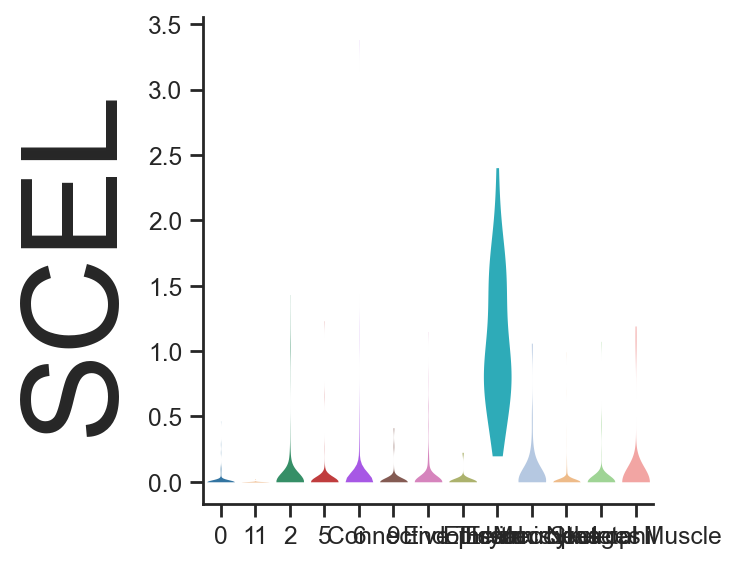

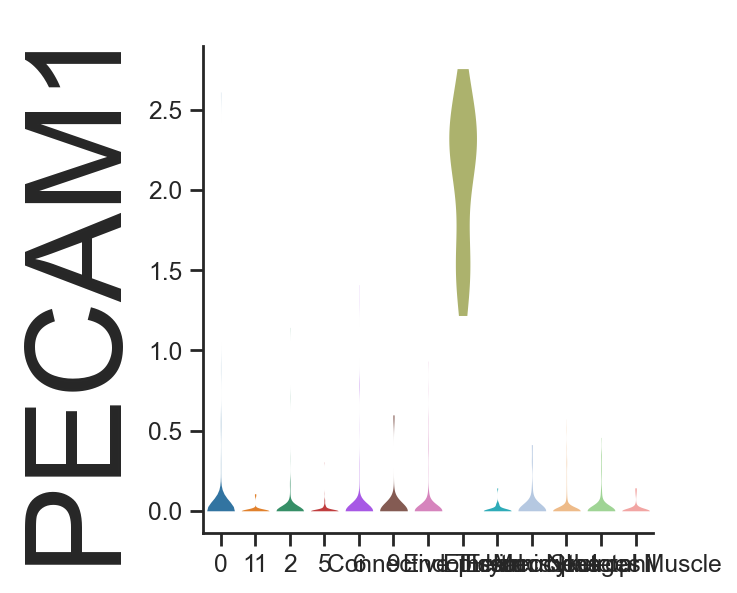

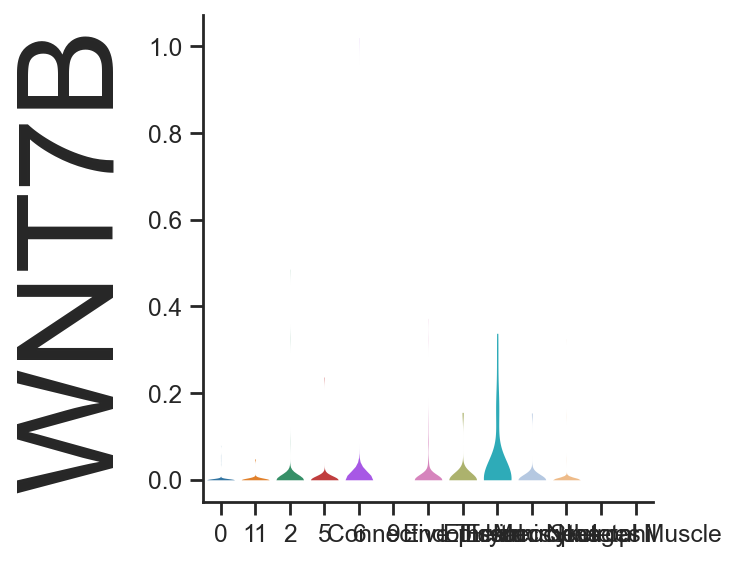

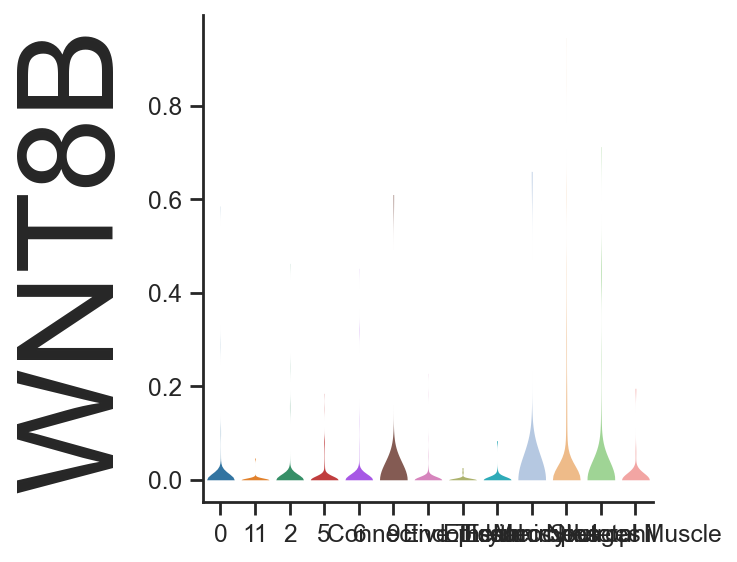

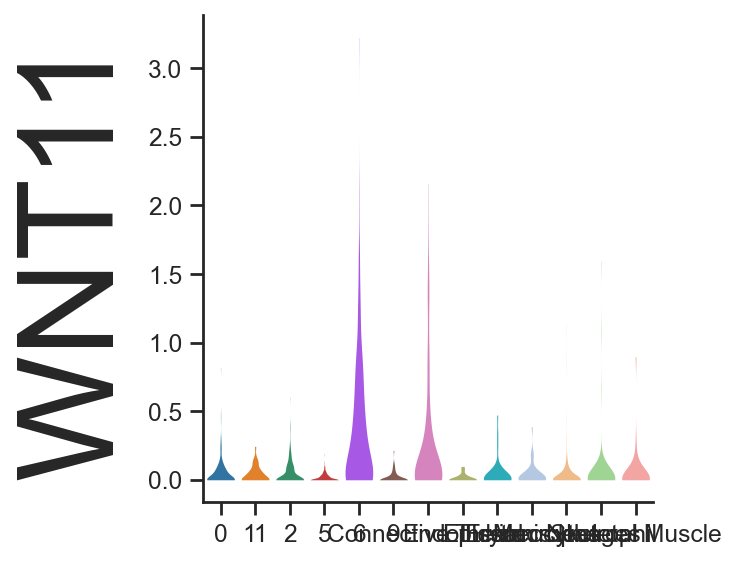

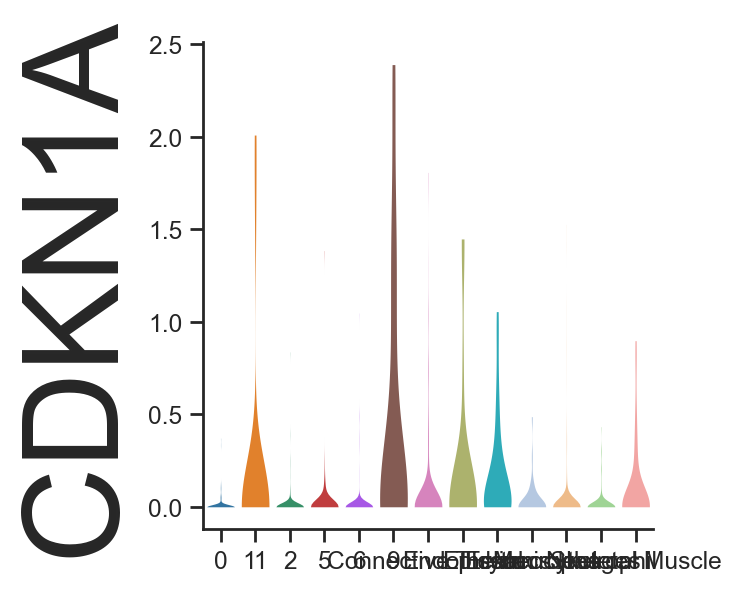

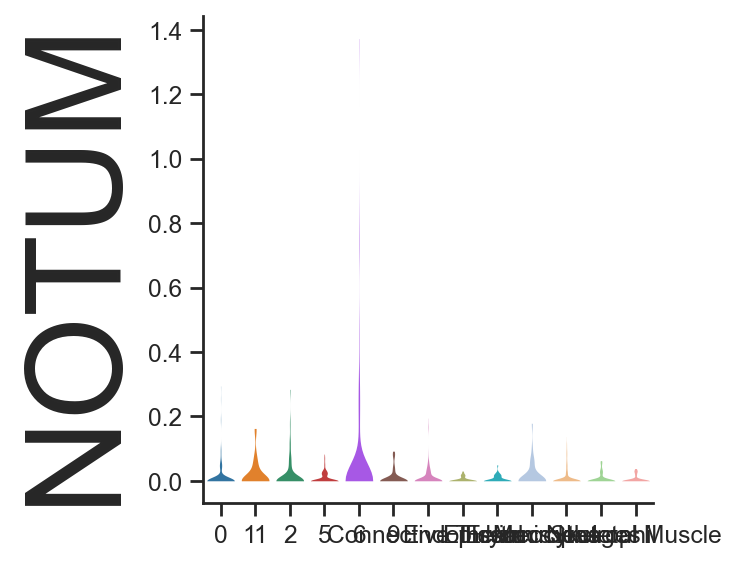

In [30]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
plt.rcParams.update({'axes.labelsize' : 60}) 

gene_list = ["C1QB","COL3A1","CFP.1","TTN","HBG1","SCEL","PECAM1",
             'WNT7B','WNT8B','WNT11','CDKN1A','NOTUM']
for gene in gene_list:
    sc.pl.violin(andy,
                 gene, 
                 'cell types',
                 jitter=False,
                 stripplot=False,
                 linewidth=0,
                 xlabel=None,
                 xticks=None,
                 save=gene+'.pdf'
                )

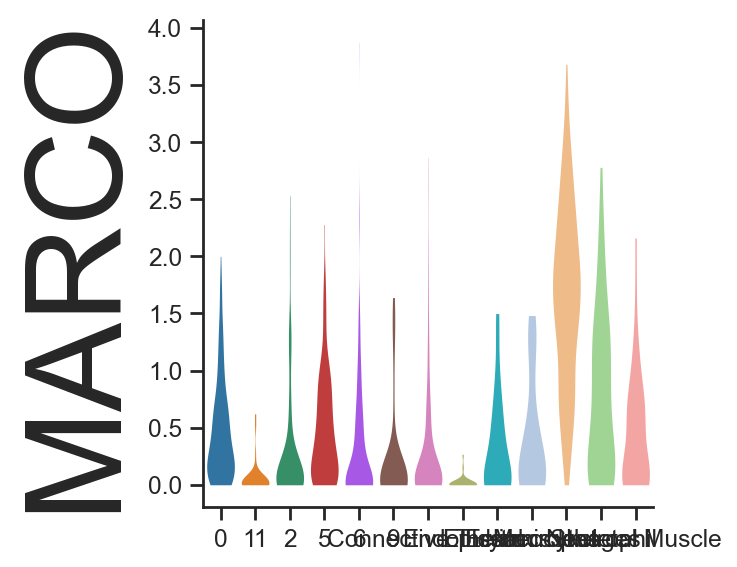

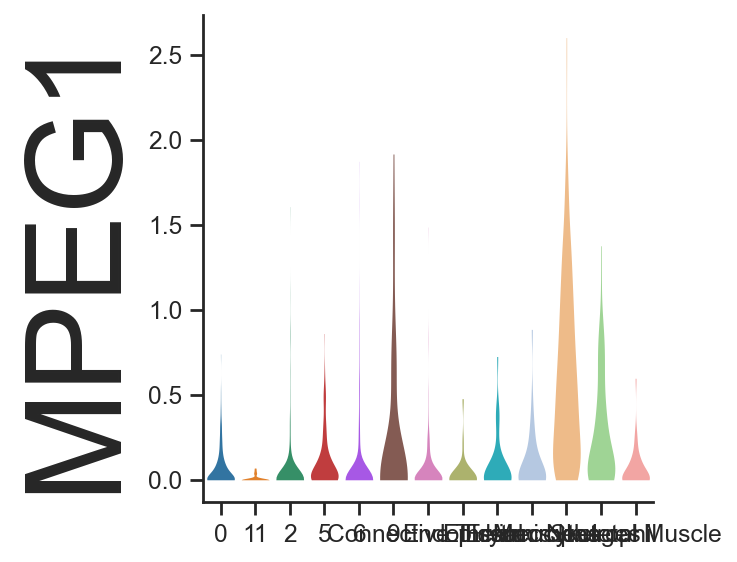

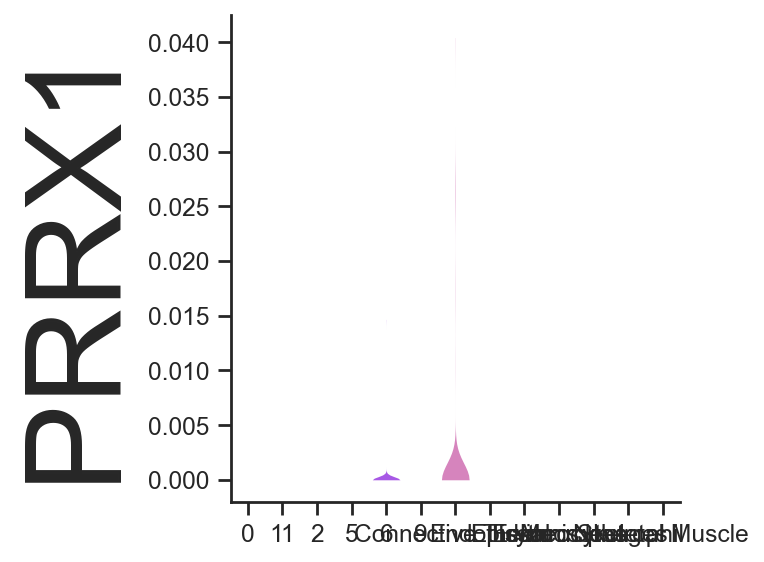

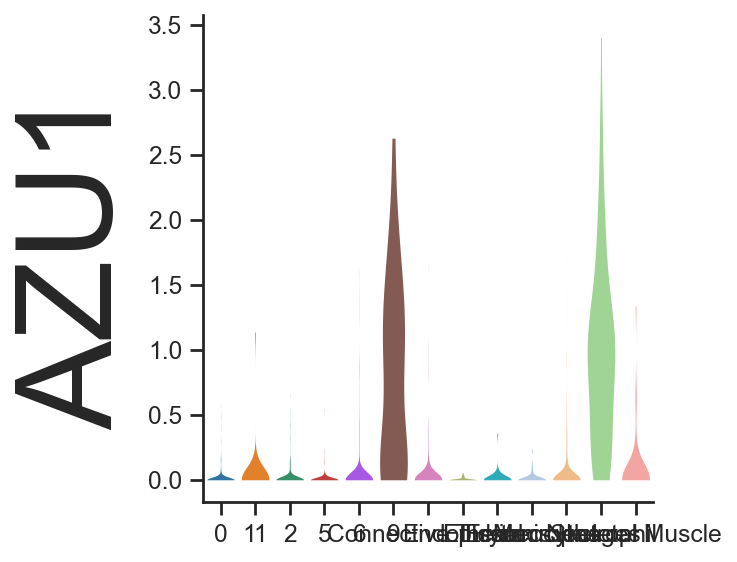

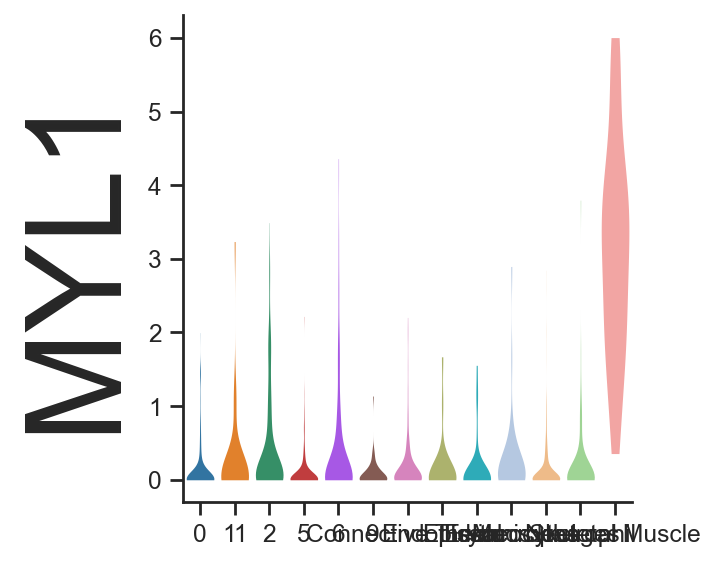

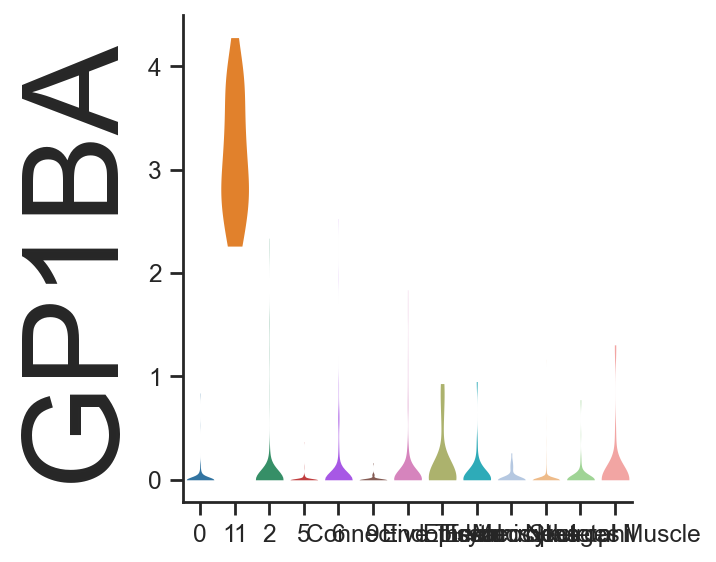

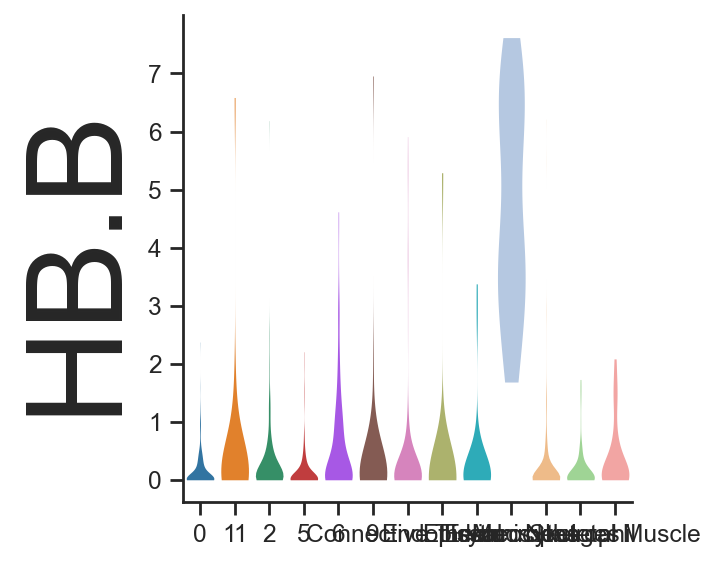

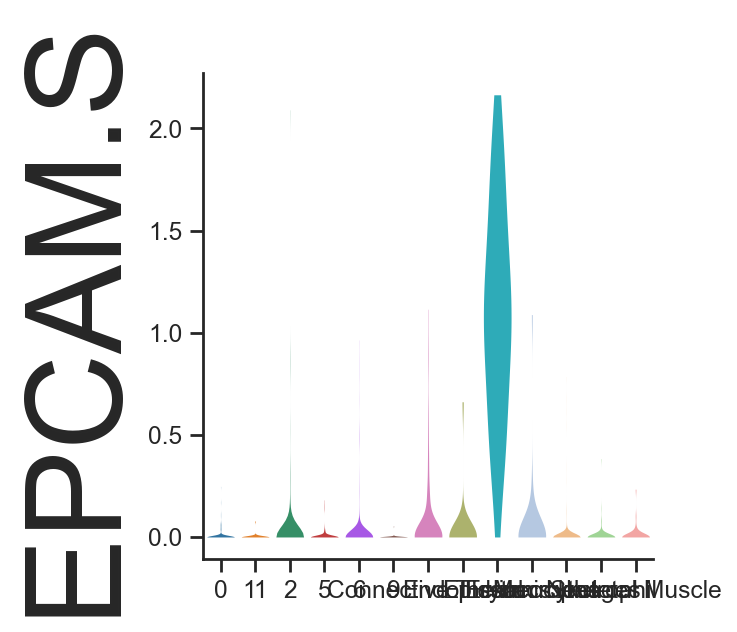

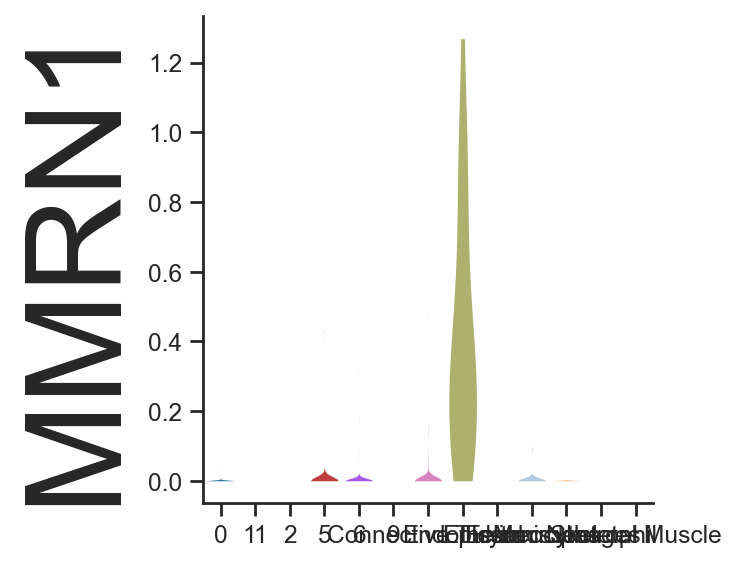

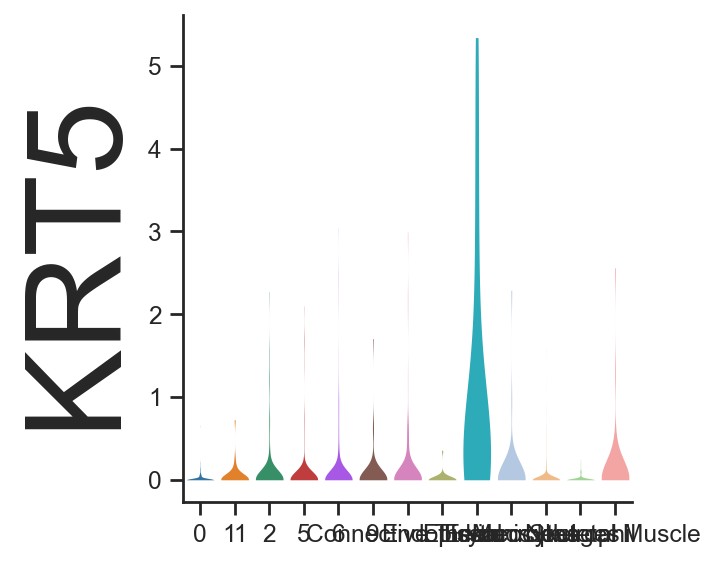

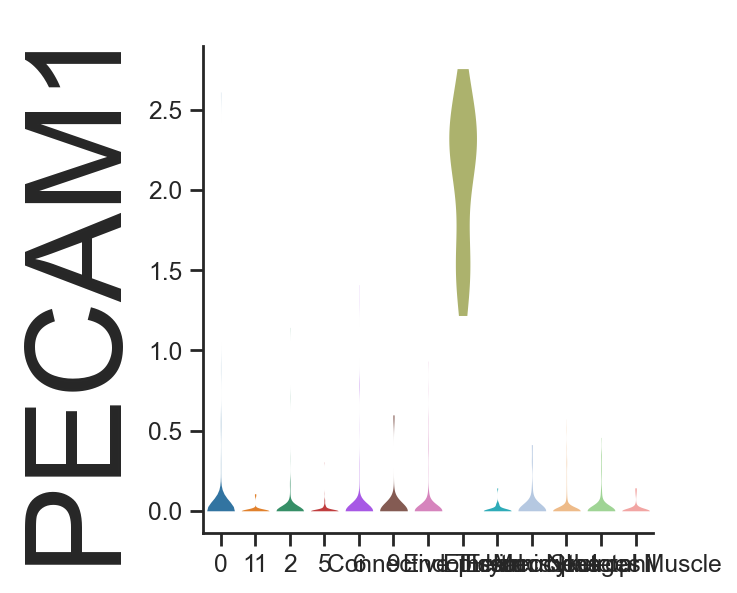

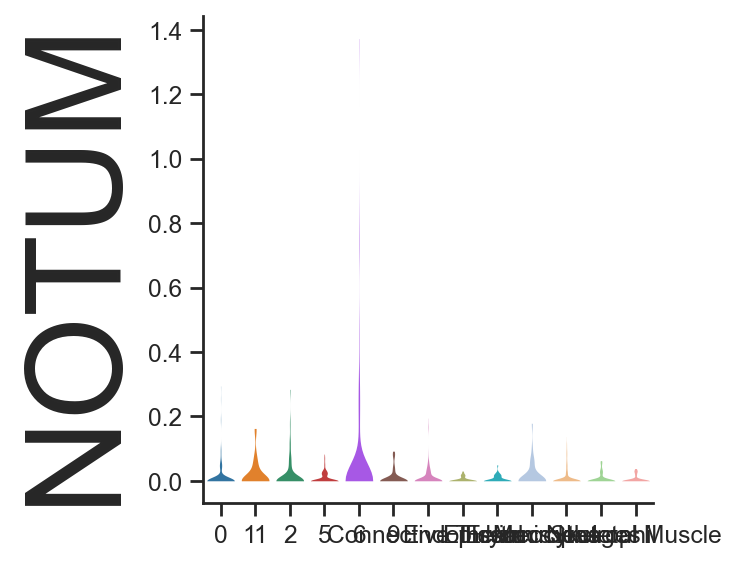

In [31]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
plt.rcParams.update({'axes.labelsize' : 60}) 

gene_list = ["MARCO","MPEG1","PRRX1","AZU1","MYL1","GP1BA","HB.B",
             'EPCAM.S','MMRN1','KRT5','PECAM1','NOTUM']
for gene in gene_list:
    sc.pl.violin(andy,
                 gene, 
                 'cell types',
                 jitter=False,
                 stripplot=False,
                 linewidth=0,
                 xlabel=None,
                 xticks=None,
                 save=gene+'.pdf'
                )

In [32]:
set(andy.obs.index.str.replace("_.._...$","",regex=True))

{'late1',
 'late2',
 'late3',
 'late4',
 'late5',
 'late6',
 'late7',
 'late8',
 'late9',
 'mid1',
 'mid11',
 'mid2',
 'mid3',
 'mid4',
 'mid6',
 'mid7',
 'mid8',
 'mid9',
 'pal1',
 'pal2',
 'pal3',
 'pal4',
 'pal5',
 'pal6',
 'pal7',
 'pal8',
 'pal9'}

In [33]:
andy.obs["batch"]=andy.obs.index.str.replace("_.._...$","",regex=True)

In [34]:
andy.uns['cell types_colors']

['#1f77b4',
 '#ff7f0e',
 '#279e68',
 '#d62728',
 '#aa40fc',
 '#8c564b',
 '#e377c2',
 '#b5bd61',
 '#17becf',
 '#aec7e8',
 '#ffbb78',
 '#98df8a',
 '#ff9896']

In [35]:
andy.obs['orig.ident']

late9_05_C14    late
pal1_01_A04      pal
pal1_01_A02      pal
pal1_01_A01      pal
pal1_01_A06      pal
                ... 
mid11_07_I06     mid
mid11_07_I07     mid
mid11_07_I08     mid
mid11_07_I09     mid
mid11_07_I10     mid
Name: orig.ident, Length: 2047, dtype: category
Categories (3, object): ['late', 'mid', 'pal']

In [36]:
andy.obs['orig.ident'].cat.set_categories(['mid', 'late', 'pal'], inplace=True)

In [37]:
cluster_props = get_cluster_proportions(andy,
                            cluster_key="cell types",
                            sample_key="orig.ident",
                            drop_values=None)

In [38]:
cluster_props

cell types          0        11          2          5          6         9  \
orig.ident                                                                   
mid         12.477718  3.743316  16.755793   6.595365  14.081996  2.317291   
late        14.634146  1.097561  16.097561  13.292683   8.658537  3.048780   
pal         10.810811  1.051051   3.603604   3.903904  22.522523  2.252252   

cell types  Connective TIssue  Endothelial  Epidermis  Erythrocytes  \
orig.ident                                                            
mid                 18.360071     1.069519   3.386809      2.852050   
late                 6.463415     1.463415   1.341463      1.585366   
pal                 12.612613     0.900901   0.900901      1.201201   

cell types  Macrophages  Neutrophil  Skeletal Muscle  
orig.ident                                            
mid           14.438503    2.495544         1.426025  
late          28.170732    2.926829         1.219512  
pal           26.876877    9.609610         3.753754

In [39]:
cluster_props.to_csv('./cell-type_proportions_axoYu.csv')

In [40]:
sns.set_theme(style="white", palette=None)
plot_cluster_proportions(cluster_props, 
                             cluster_palette=andy.uns['cell types_colors'],
                             xlabel_rotation=90)
plt.savefig("./figures/cell_types_proportions.pdf", dpi=500)

... storing 'batch' as categorical


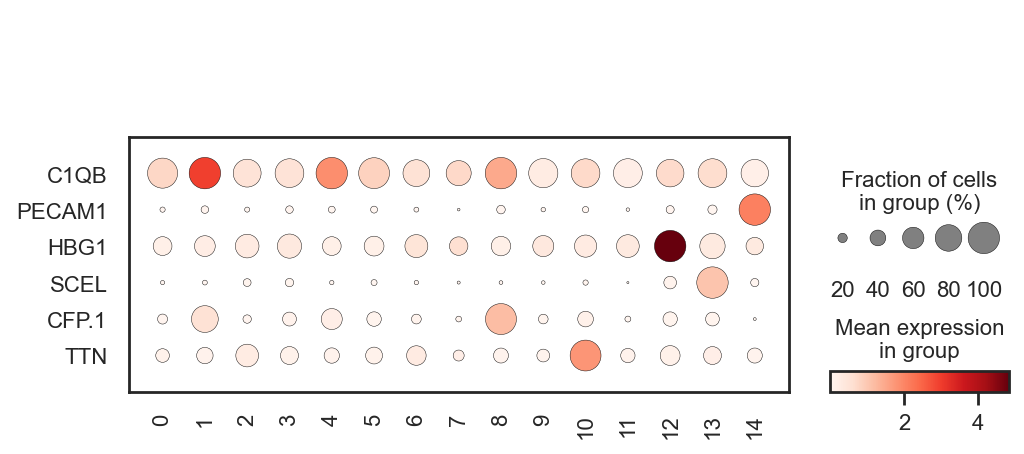

In [41]:
sc.pl.dotplot(andy, ["C1QB", "PECAM1","HBG1","SCEL","CFP.1","TTN"], "seurat_clusters", swap_axes=True)

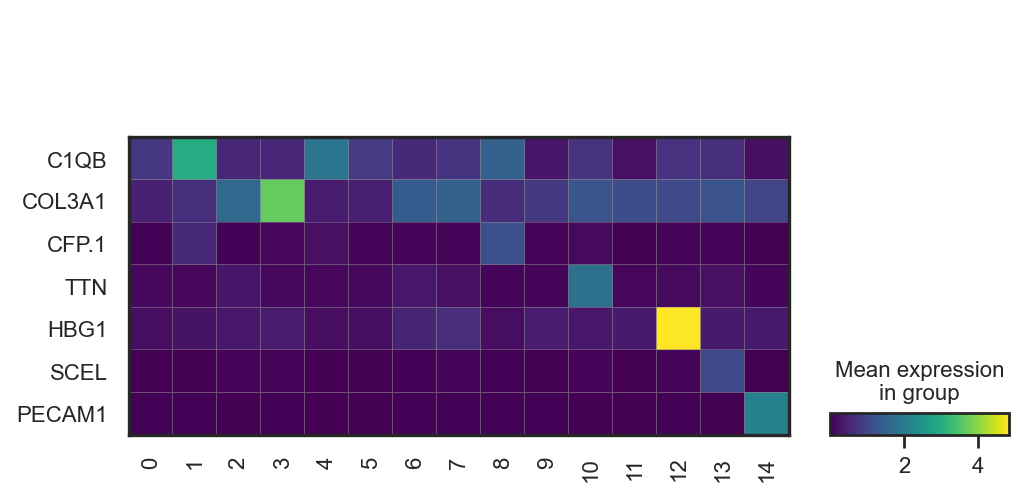

In [42]:
sc.pl.matrixplot(andy, ["C1QB","COL3A1","CFP.1","TTN","HBG1","SCEL","PECAM1"], "seurat_clusters", swap_axes=True)

In [43]:
common = pd.read_csv("../Bulk/common_UPgenes_symbolANDid.csv")
common.head()

gene_id          symbol
0  AMEX60DD002123  AMEX60DD002123
1  AMEX60DD002209  AMEX60DD002209
2  AMEX60DD003570  AMEX60DD003570
3  AMEX60DD004025  AMEX60DD004025
4  AMEX60DD004026  AMEX60DD004026

In [44]:
sc.tl.score_genes(andy, 
                      common.symbol, 
                      ctrl_size=50, 
                      gene_pool=None, 
                      n_bins=25, 
                      score_name='CommonBulkScore', 
                      random_state=0, copy=False, use_raw=False)

computing score 'CommonBulkScore'
    finished: added
    'CommonBulkScore', score of gene set (adata.obs).
    500 total control genes are used. (0:00:00)


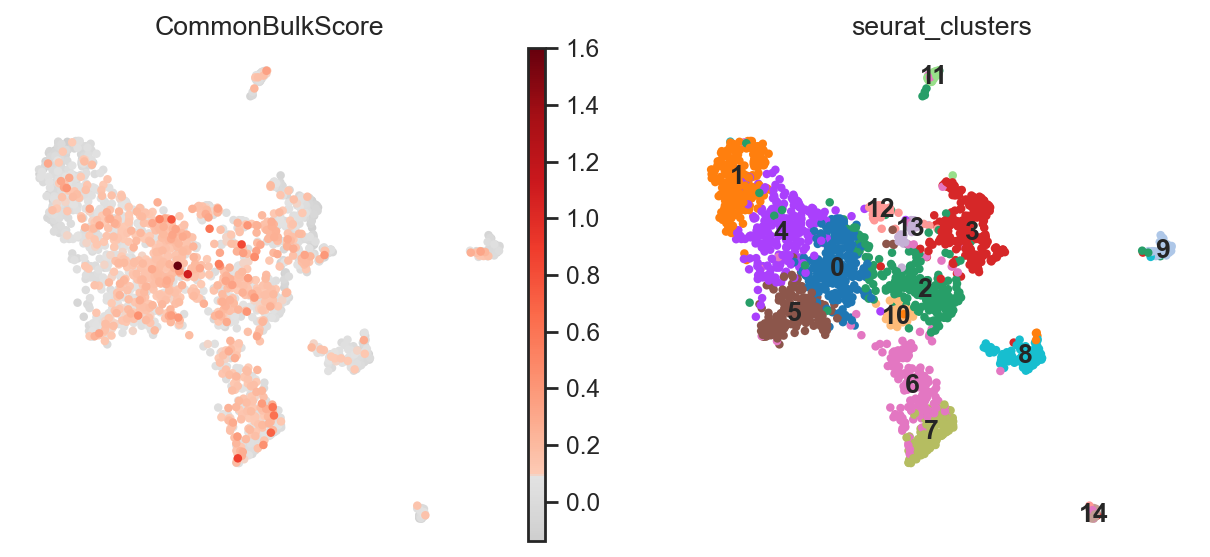

In [45]:
sc.pl.umap(andy, color=['CommonBulkScore','seurat_clusters'], legend_loc="on data", use_raw=False, color_map = mymap, frameon=False)


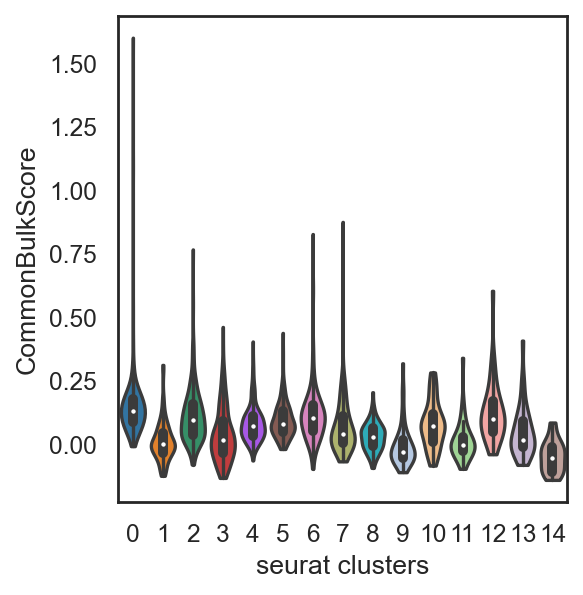

In [46]:
sc.pl.violin(andy, ['CommonBulkScore'], groupby='seurat_clusters' , stripplot=False, inner='box')
# sc.pl.violin(andy, ['CommonBulkScore'], groupby='dataset' , stripplot=False, inner='box')

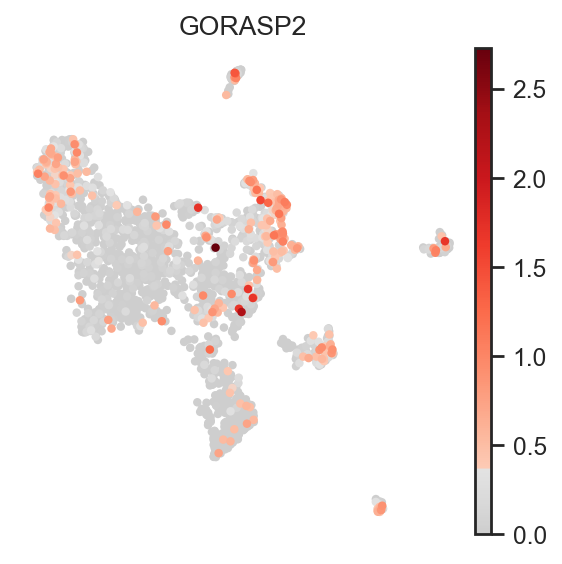

In [47]:
sc.pl.umap(andy, color=['GORASP2'], legend_loc="on data", use_raw=False, color_map = mymap, frameon=False)


In [48]:
rRNA = pd.read_csv('../gene_sets/rRNA_transcripts.txt', names=['rRNA'])

In [49]:
rRNA_genes = [x for x in andy.var_names if x in list(rRNA.iloc[:,0])]
len(rRNA_genes)

16

In [50]:
sc.tl.score_genes(andy, 
                      rRNA_genes, 
                      ctrl_size=50, 
                      gene_pool=None, 
                      n_bins=25, 
                      score_name='rRNA_score', 
                      random_state=0, copy=False, use_raw=False)

computing score 'rRNA_score'
    finished: added
    'rRNA_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)


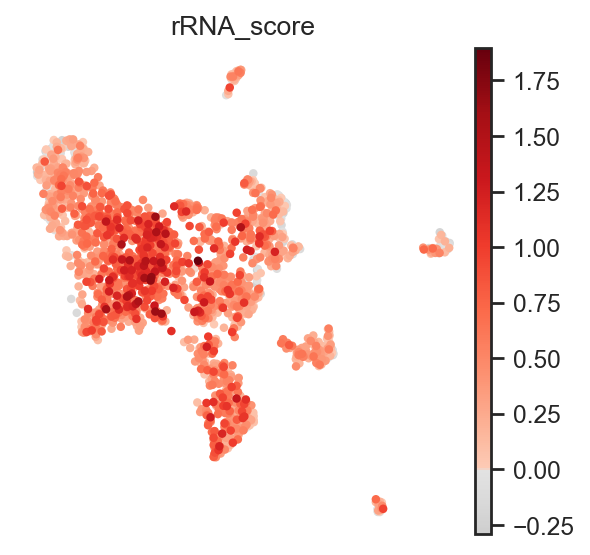

In [53]:
sc.pl.umap(andy, color=['rRNA_score'],
           legend_loc="on data",
           use_raw=False, 
           color_map = mymap,
           save='_rRNA_score.pdf',
           frameon=False)
